<h1>
<hr style=" border:none; height:3px;">
<center>Computer Vision - Annotation pipeline</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Paul-Alexandre MARENGHI</center></h4>

# 0. Import

In [1]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon, box

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import torch
from torchvision import transforms
from transformers import AutoImageProcessor, Dinov2Model

In [2]:
chessboard_folder = 'data/chessboard'
chess_pieces_folder = 'data/chess_pieces'

INPUT_SIZE = 1080

# I. Function to preprocess the image

### I.1 Crop and wrap image

In [3]:
def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [4]:
def reorder_points(pts):
    """
    Sort corners into order: 
        [top-left, top-right, bottom-right, bottom-left]
    """
    pts = pts.astype(np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    ordered = np.zeros((4, 2), dtype=np.float32)
    ordered[0] = pts[np.argmin(s)]      # top-left
    ordered[2] = pts[np.argmax(s)]      # bottom-right
    ordered[1] = pts[np.argmin(diff)]   # top-right
    ordered[3] = pts[np.argmax(diff)]   # bottom-left
    return ordered

def detect_corners(img):
    """
    Inspired by Sudoku detection approach:
    1) Grayscale, blur
    2) Adaptive threshold
    3) Morphological closing
    4) Find largest contour that isn't too small or too large
    5) Approximate to 4 corners -> return
    6) Otherwise fallback to rotated bounding box
    """
    # 1) Grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # 2) Adaptive threshold (makes the board region bright/white)
    #    We invert so that the board is white on black background
    thresh = cv2.adaptiveThreshold(
        gray_blur, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11,    # blockSize
        2      # C constant subtracted from mean
    )
    # Invert: the board area becomes white, background black
    thresh = cv2.bitwise_not(thresh)

    # 3) Morphological closing to fill gaps in the board edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4) Find contours in the closed image
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Sort by descending area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    img_area = img.shape[0] * img.shape[1]

    # Attempt to find a 4-corner polygon
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Filter out tiny or massive (entire image) contours
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue

        # Approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # If we get 4 corners, reorder and return
        if len(approx) == 4:
            corners = approx.reshape(4, 2)
            return reorder_points(corners)

    # 5) Fallback: if no 4-corner polygon found, 
    #    use minAreaRect on the largest plausible contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue
        rect = cv2.minAreaRect(cnt)   # ((cx,cy),(w,h),angle)
        box = cv2.boxPoints(rect)     # 4 corner points
        return reorder_points(box)

    return None

def warp_perspective(image, corners):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    image = np.array(image)

    rect = order_points(np.array(corners, dtype="float32"))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

### I.2 Detect chessboard squares

In [5]:
def detect_straight_lines(edges, threshold=100, min_line_length=50, max_line_gap=10):
    """
    Détecte les lignes droites sur une image de bords (Canny) en utilisant la transformée de Hough.
    :param edges: Image binaire des bords obtenue avec Canny.
    :param threshold: Seuil pour la détection des lignes.
    :param min_line_length: Longueur minimale pour qu'une ligne soit prise en compte.
    :param max_line_gap: Distance max entre deux segments pour être considérés comme une seule ligne.
    :return: Liste des lignes détectées sous forme de tuples (x1, y1, x2, y2).
    """
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    return [] if lines is None else [tuple(line[0]) for line in lines]

In [6]:
def extend_line(x1, y1, x2, y2, img_shape):
    """
    Prolonge une ligne (x1, y1, x2, y2) en respectant son angle, pour qu'elle couvre toute l'image.
    """
    height, width = img_shape[:2]

    # Calcul de l'angle et direction
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)  # Pente de la ligne
        y_intercept = y1 - slope * x1  # Ordonnée à l'origine

        # Prolongement vers la gauche (x = 0) et la droite (x = width)
        x_left, y_left = 0, int(y_intercept)
        x_right, y_right = width, int(slope * width + y_intercept)

        # Clamping des valeurs pour rester dans l'image
        if y_left < 0 or y_left > height:
            y_left = max(0, min(y_left, height))
            x_left = int((y_left - y_intercept) / slope)

        if y_right < 0 or y_right > height:
            y_right = max(0, min(y_right, height))
            x_right = int((y_right - y_intercept) / slope)
        
        return (x_left, y_left, x_right, y_right)

    else:  # Cas particulier d'une ligne verticale
        return (x1, 0, x2, height)

def draw_extended_lines(image, lines):
    """
    Dessine les lignes prolongées sur l'image.
    """
    img_with_lines = image.copy()
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, img_with_lines.shape)
        cv2.line(img_with_lines, (extended_line[0], extended_line[1]), 
                 (extended_line[2], extended_line[3]), (0, 255, 0), 2)

    return img_with_lines

In [7]:
import math

def extended_lines(lines, image):
    extended_lines = []
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, image.shape)
        extended_lines.append(extended_line)
    return extended_lines

def avg_extended_lines(lines, image, threshold=30):
    extented_lines = extended_lines(lines, image)
    merged_lines = []
    merged = set()  # Utilisation d'un ensemble pour éviter les doublons et optimiser les recherches

    for x1, y1, x2, y2 in extented_lines:
        if (x1, y1, x2, y2) not in merged:
            to_merge = [(x1, y1, x2, y2)]
            for x3, y3, x4, y4 in extented_lines:
                if (x3, y3, x4, y4) not in merged and (x3, y3, x4, y4) not in to_merge:
                    if math.dist((x1, y1), (x3, y3)) < threshold and math.dist((x2, y2), (x4, y4)) < threshold:
                        to_merge.append((x3, y3, x4, y4))

            # Moyenne des points des lignes fusionnées
            avg_x1 = sum(x[0] for x in to_merge) // len(to_merge)
            avg_y1 = sum(x[1] for x in to_merge) // len(to_merge)
            avg_x2 = sum(x[2] for x in to_merge) // len(to_merge)
            avg_y2 = sum(x[3] for x in to_merge) // len(to_merge)

            # Ajout des lignes fusionnées à l'ensemble des lignes traitées
            merged.update(to_merge)
            merged_lines.append((avg_x1, avg_y1, avg_x2, avg_y2))
        
    return merged_lines

In [8]:
def classify_lines(lines, img_width, margin=0.1):
    """
    Classe les lignes en quasi-horizontales ou quasi-verticales 
    en fonction de la position de leurs extrémités dans l'image.

    Paramètres :
        - lines : liste des lignes [(x1, y1, x2, y2)]
        - img_width : largeur de l'image (pour évaluer les limites gauche/droite)
        - margin : pourcentage de la largeur de l'image utilisé comme seuil (ex: 10%)

    Retour :
        - horizontal : liste des lignes horizontales
        - vertical : liste des lignes verticales
    """
    horizontal = []
    vertical = []

    left_limit = img_width * margin  # Seuil gauche
    right_limit = img_width * (1 - margin)  # Seuil droit

    for x1, y1, x2, y2 in lines:
        if (min(x1, x2) < left_limit) and (max(x1, x2) > right_limit):  
            horizontal.append((x1, y1, x2, y2))  # Lignes horizontales
        else:
            vertical.append((x1, y1, x2, y2))  # Lignes verticales

    return horizontal, vertical

def find_intersections(lines1, lines2):
    """Trouve les points d'intersection entre deux groupes de lignes en résolvant les équations des droites."""
    pts_on_vertical_lines = {}
    pts_on_horizontal_lines = {}
    intersections = []
    for (x1, y1, x2, y2) in lines1:
        for (x3, y3, x4, y4) in lines2:
            # Calcul des coefficients des droites
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if abs(denom) < 1e-6:  # Lignes parallèles
                continue

            # Calcul des coordonnées d'intersection
            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

            # if 0 <= px <= cropped.shape[1] and 0 <= py <= cropped.shape[0]:  # Vérifie que le point est dans l'image
            intersections.append((int(px), int(py)))

            if (x1, y1, x2, y2) not in pts_on_horizontal_lines:
                pts_on_horizontal_lines[(x1, y1, x2, y2)] = [(int(px),int(py))]
            else:
                pts_on_horizontal_lines[(x1, y1, x2, y2)].append((int(px),int(py)))
            
            if (x3, y3, x4, y4) not in pts_on_vertical_lines:
                pts_on_vertical_lines[(x3, y3, x4, y4)] = [(int(px),int(py))]
            else:
                pts_on_vertical_lines[(x3, y3, x4, y4)].append((int(px),int(py)))

    return intersections, pts_on_horizontal_lines, pts_on_vertical_lines

In [9]:
def most_regular_segment(points, min_length=8, max_length=9, threshold=0.5):
    """
    Trouve la séquence de 8 ou 9 points les plus régulièrement espacés,
    en priorisant une séquence de 9 si elle est acceptable.
    Si une séquence de 8 est choisie, on ajoute un 9ᵉ point à l'opposé du bord le plus proche.

    :param points: Liste de tuples (x, y) représentant les points d'une droite.
    :param min_length: Longueur minimale du segment (8 par défaut).
    :param max_length: Longueur maximale du segment (9 par défaut).
    :param threshold: Seuil d'écart-type maximal pour considérer une séquence de 9 comme acceptable.
    :return: Liste de 9 points les plus régulièrement espacés.
    """
    n = len(points)
    if n < min_length:
        return points  # Pas assez de points pour former un segment valide

    best_segment_9 = None
    best_segment_8 = None
    min_variation_9 = float('inf')
    min_variation_8 = float('inf')
    best_start_8 = None  # Indice du début du segment de 8

    # Essayer toutes les sous-séquences de taille 8 et 9
    for start in range(n):
        for length in [9, 8]:  # Priorité à 9
            end = start + length
            if end > n:
                continue
            
            segment = points[start:end]

            # Calcul des distances successives entre les points
            distances = [np.linalg.norm(np.array(segment[j+1]) - np.array(segment[j])) for j in range(len(segment) - 1)]
            
            # Calcul de l'écart-type des distances pour mesurer la régularité
            variation = np.std(distances)

            # Vérifier si c'est une séquence de 9 acceptable
            if length == 9 and variation < min_variation_9:
                min_variation_9 = variation
                best_segment_9 = segment

            # Vérifier si c'est une séquence de 8 meilleure
            if length == 8 and variation < min_variation_8:
                min_variation_8 = variation
                best_segment_8 = segment
                best_start_8 = start

    # Si la séquence de 9 est suffisamment régulière, la retourner
    if best_segment_9 and min_variation_9 <= threshold:
        return best_segment_9

    # Sinon, retourner la meilleure séquence de 8 et ajouter un point à l'opposé du bord le plus proche
    if best_segment_8:
        start = best_start_8
        end = start + 8

        # Déterminer les candidats à ajouter (point avant ou après la séquence)
        left_point = points[start - 1] if start > 0 else None
        right_point = points[end] if end < n else None

        # Trouver le bord le plus proche
        if left_point and right_point:
            left_dist = np.linalg.norm(np.array(left_point) - np.array(best_segment_8[0]))
            right_dist = np.linalg.norm(np.array(right_point) - np.array(best_segment_8[-1]))

            if left_dist < right_dist:
                best_segment_8.append(right_point)  # Ajouter à droite (opposé de gauche)
            else:
                best_segment_8.insert(0, left_point)  # Ajouter à gauche (opposé de droite)
        elif left_point:
            best_segment_8.append(left_point)  # Ajouter à droite si possible
        elif right_point:
            best_segment_8.insert(0, right_point)  # Ajouter à gauche si possible

        return best_segment_8

    return None 

def points_to_keep(pts_on_horizontal_lines, pts_on_vertical_lines):
    horizontal_points_to_keep = []
    for line in pts_on_horizontal_lines:
        sorted_points = sorted(pts_on_horizontal_lines[line], key=lambda x: x[0])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in horizontal_points_to_keep:
                horizontal_points_to_keep.append(point)
    
    vertical_points_to_keep = []
    for line in pts_on_vertical_lines:
        sorted_points = sorted(pts_on_vertical_lines[line], key=lambda x: x[1])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in vertical_points_to_keep:
                vertical_points_to_keep.append(point)
    
    points_to_keep = [point for point in horizontal_points_to_keep if point in vertical_points_to_keep]
    return points_to_keep

In [10]:
def group_points_by_y(points, threshold=10, min_points=9):
    grouped_points = []
    temp_group = []
    
    for x, y in sorted(points, key=lambda p: p[1]):
        if not temp_group or abs(temp_group[-1][1] - y) <= threshold:
            temp_group.append((x, y))
        else:
            if len(temp_group) >= min_points:
                grouped_points.append(temp_group)
            temp_group = [(x, y)]
    
    if len(temp_group) >= min_points:
        grouped_points.append(temp_group)
    
    return grouped_points


def center_points(grid_points):
    sorted_grid_points = sorted(grid_points, key=lambda x:x[0]) # Selon x
    sorted_grid_points = sorted(sorted_grid_points, key=lambda x: x[1]) # Selon y
    points_per_lines = group_points_by_y(sorted_grid_points)

    center_points = []

    lines_nb = len(points_per_lines)
    for line_i in range(lines_nb-1):
        line0 = points_per_lines[line_i]
        line1 = points_per_lines[line_i+1]

        points_nb = min(len(line0), len(line1))
        for point_i in range(points_nb-1):
            x_point0, y_point0 = line0[point_i]
            x_point1, y_point1 = line0[point_i+1]
            x_point2, y_point2 = line1[point_i]
            x_point3, y_point3 = line1[point_i+1]

            x_center_point = ( x_point0 + x_point1 + x_point2 + x_point3 ) // 4
            y_center_point = ( y_point0 + y_point1 + y_point2 + y_point3 ) // 4
            center_points.append((x_center_point, y_center_point))
    
    return center_points

In [11]:
def square_length(grid_points):
    sorted_grid_points = sorted(grid_points, key=lambda x:x[0]) # Selon x
    sorted_grid_points = sorted(sorted_grid_points, key=lambda x: x[1]) # Selon y
    points_per_lines = group_points_by_y(sorted_grid_points)

    tot_square_length = 0
    nb1 = 0
    for line in points_per_lines:
        points_nb = len(line)
        for i in range(points_nb-1):
            x1, y1 = line[i]
            x2, y2 = line[i+1]
            dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            tot_square_length += dist
            nb1 += 1
    
    tot_square_height = 0
    nb2 = 0
    nb_lines = len(points_per_lines)
    for i in range(nb_lines-1):
        line0, line1 = points_per_lines[i], points_per_lines[i+1]
        points_nb = min(len(line0), len(line1))
        for j in range(points_nb):
            x0, y0 = line0[j]
            x1, y1 = line1[j]
            dist = math.sqrt((x1-x0)**2 + (y1-y0)**2)
            tot_square_height += dist
            nb2 += 1
    
    avg_square_length = int((tot_square_length + tot_square_height) // (nb1 + nb2)) // 2
    return avg_square_length

In [12]:
def show_cells(cells_dict, grid_size=8):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    labels = sorted(cells_dict.keys())
    
    for idx, label in enumerate(labels):
        i, j = divmod(idx, grid_size)
        cell_rgb = cv2.cvtColor(cells_dict[label], cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(cell_rgb)
        axs[i, j].axis('off')
        axs[i, j].set_title(label, fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [13]:
def split_image(img, center_points, avg_square_length, length_threshold=10, height_threshold=50):
    board_mapping = {}
    chess_columns = 'abcdefgh'
    
    for idx, (i, j) in enumerate(center_points):
        row = 8 - (idx // 8)
        col = chess_columns[idx % 8]
        position = f"{col}{row}"
        
        x_start, y_start = max(int(i - avg_square_length - length_threshold / 2), 0) , max(int(j - avg_square_length - height_threshold/ 2), 0)
        x_end, y_end = min(int(i + avg_square_length + length_threshold/ 2), img.shape[0]), min(int(j + avg_square_length +height_threshold / 2), img.shape[1])
        
        split_img = img[y_start:y_end, x_start:x_end]
        board_mapping[position] = split_img
    
    return board_mapping

In [14]:
def show_cells(cells_dict, fig_length=6, fig_height=6):
    grid_size=8
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(fig_length, fig_height))
    labels = sorted(cells_dict.keys(), key=lambda label: (int(label[1]), label[0]))
    
    for idx, label in enumerate(labels):
        i, j = divmod(idx, grid_size)
        i = grid_size - 1 - i  # Inverser l'axe vertical pour que 'a' soit en bas
        cell = cells_dict[label]
        if cell is not None and cell.size > 0:
            cell_rgb = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(cell_rgb)
        else:
            axs[i, j].imshow(np.zeros((10, 10, 3), dtype=np.uint8))
        axs[i, j].axis('off')
        axs[i, j].set_title(label, fontsize=8)
    
    plt.tight_layout()
    plt.show()

### I.4 Piece detection

In [15]:
# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load DINOv2 Model and Processor ---
model_id = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_id)
model = Dinov2Model.from_pretrained(model_id).to(device)
model.eval()

# --- Preprocess image for DINOv2 ---
def preprocess(image):
    inputs = processor(images=image, return_tensors="pt")
    return inputs['pixel_values'].to(device)

# --- Extract feature embedding ---
def get_embedding(image):
    with torch.no_grad():
        pixel_values = preprocess(image)
        outputs = model(pixel_values)
        embedding = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        return embedding.squeeze()

# --- Load reference piece embeddings ---
def load_reference_embeddings(asset_folder):
    references = {}
    for label in os.listdir(asset_folder):
        label_path = os.path.join(asset_folder, label)
        if os.path.isdir(label_path):
            embeddings = []
            for file in os.listdir(label_path):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(label_path, file)
                    img = Image.open(img_path).convert("RGB")
                    emb = get_embedding(img)
                    embeddings.append(emb)
            if embeddings:
                # Average embeddings for this class
                stacked = torch.stack(embeddings)
                references[label] = stacked.mean(dim=0)
    return references

# --- Cosine similarity ---
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

# --- Compare each square to references ---
def classify_board_cells(cell_images, reference_embeddings):
    results = []
    for img in cell_images:
        emb = get_embedding(img)
        similarities = {
            label: cosine_similarity(emb, ref_emb) for label, ref_emb in reference_embeddings.items()
        }
        top3 = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:3]
        top3_labels = [label for label, _ in top3]
        label_counts = Counter(top3_labels)
        most_common = label_counts.most_common(1)[0]
        if most_common[1] > 1:
            final_label = most_common[0]
        else:
            final_label = top3_labels[0]
        results.append(final_label)
    return results

# --- Chess notation helper ---
def get_notation(row, col):
    return f"{chr(ord('A') + col)}{8 - row}"

### I.5 Chessboard visualisation

In [16]:
def remove_checkerboard_background(img):
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        r, g, b, a = item
        if r > 200 and g > 200 and b > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append((r, g, b, a))
    img.putdata(newData)
    return img

def visualize_board(classified_labels):
    board = np.array(classified_labels).reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels([chr(i) for i in range(65, 73)])
    ax.set_yticklabels(list(reversed(range(1, 9))))
    ax.imshow([[1 if (i + j) % 2 == 0 else 0.7 for j in range(8)] for i in range(8)],
              cmap='Blues', extent=(0, 8, 0, 8))

    for i in range(8):
        for j in range(8):
            piece = board[i][j]
            if piece not in ["white_cell", "black_cell"]:
                image_path = os.path.join("./2d_assets", piece, f"{piece}.png")
                if os.path.exists(image_path):
                    img = Image.open(image_path)
                    img = remove_checkerboard_background(img)
                    img = img.resize((40, 40), resample=Image.Resampling.LANCZOS)
                    im = OffsetImage(img, zoom=1, interpolation='none')
                    ab = AnnotationBbox(im, (j + 0.5, i + 0.5), frameon=False)
                    ax.add_artist(ab)

    plt.grid(False)
    plt.title("Detected Chess Board Pieces")
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.gca().invert_yaxis()
    plt.show()


In [17]:
def extract_labeled_cells_from_dict(image_dict, grid_size=8):
    all_cells = []

    files = 'abcdefgh'
    ranks = '87654321'

    for i in range(grid_size):
        for j in range(grid_size):
            _key_ = files[j] + ranks[i]
            for key, image in image_dict.items():
                if key == _key_:
                    all_cells.append(image)

    return all_cells

# Extraction

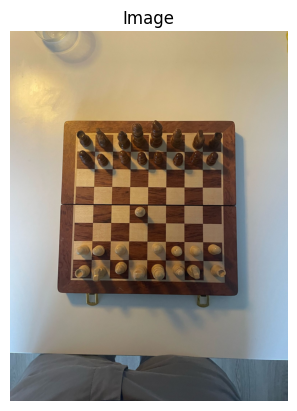

In [36]:
image_path = "data\chessboard\chessboard_6.jpg"
image = cv2.imread(image_path)
show_image_rgb(image, title="Image")

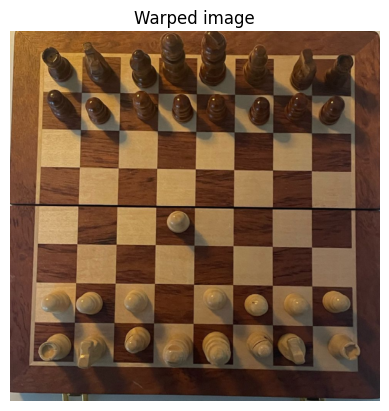

In [37]:
corners = detect_corners(image)
warped = warp_perspective(image, corners)
cropped = cv2.resize(warped, (INPUT_SIZE, INPUT_SIZE), interpolation=cv2.INTER_AREA)
show_image_rgb(cropped, title="Warped image")

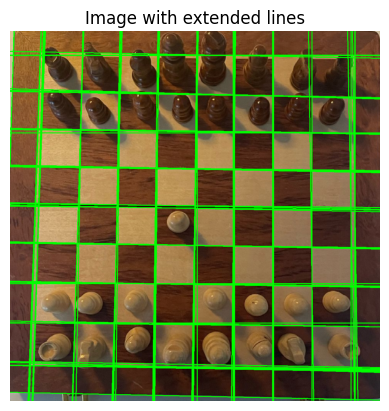

In [38]:
cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
cropped_blur = cv2.GaussianBlur(cropped_gray, (7, 7), 2)
edges = cv2.Canny(cropped_blur, 50, 150)
lines = detect_straight_lines(edges)

image_with_extended_lines = draw_extended_lines(cropped, lines)
show_image_rgb(image_with_extended_lines, "Image with extended lines")

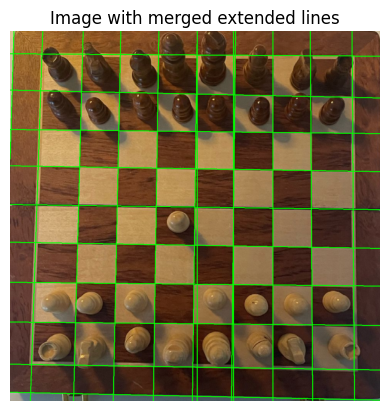

In [39]:
grouped_lines = avg_extended_lines(lines, cropped, threshold=50)
image_with_merged_extended_lines = draw_extended_lines(cropped, grouped_lines)
show_image_rgb(image_with_merged_extended_lines, "Image with merged extended lines")

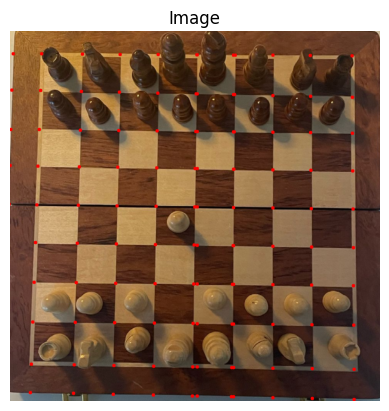

In [40]:
horizontal_lines, vertical_lines = classify_lines(grouped_lines, cropped.shape[0])
intersections, pts_on_horizontal_lines, pts_on_vertical_lines = find_intersections(horizontal_lines, vertical_lines)

cropped_with_init_grid_points = cropped.copy()
for (px, py) in intersections:
    cv2.circle(cropped_with_init_grid_points, (px, py), 5, (0, 0, 255), -1)
show_image_rgb(cropped_with_init_grid_points)

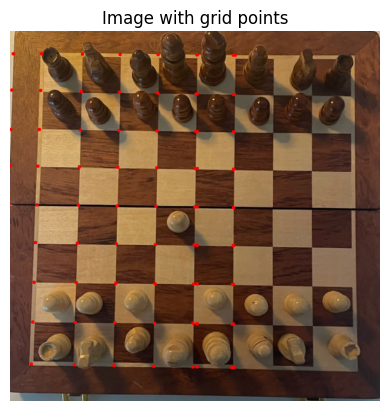

In [41]:
grid_points = points_to_keep(pts_on_horizontal_lines, pts_on_vertical_lines)

cropped_with_grid_points= cropped.copy()
for (px, py) in grid_points:
        cv2.circle(cropped_with_grid_points, (px, py), 5, (0, 0, 255), -1)
show_image_rgb(cropped_with_grid_points, "Image with grid points")

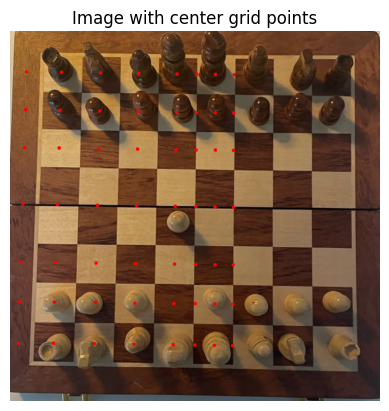

In [42]:
grid_center_points = center_points(grid_points)

cropped_with_center_grid_points= cropped.copy()
for (px, py) in grid_center_points:
        cv2.circle(cropped_with_center_grid_points, (px, py), 5, (0, 0, 255), -1)
show_image_rgb(cropped_with_center_grid_points, "Image with center grid points")

In [43]:
avg_square_length = square_length(grid_points)
board_mapping = split_image(cropped, grid_center_points, avg_square_length, length_threshold=70, height_threshold=90)
print(board_mapping)

{'a8': array([[[150, 194, 218],
        [152, 197, 221],
        [150, 196, 220],
        ...,
        [ 51, 107, 165],
        [ 49, 105, 164],
        [ 51, 108, 166]],

       [[151, 194, 218],
        [151, 197, 221],
        [149, 195, 219],
        ...,
        [ 58, 113, 172],
        [ 55, 109, 169],
        [ 53, 108, 167]],

       [[151, 195, 219],
        [150, 196, 220],
        [148, 194, 218],
        ...,
        [ 63, 117, 177],
        [ 58, 112, 172],
        [ 54, 108, 167]],

       ...,

       [[170, 191, 206],
        [173, 193, 207],
        [176, 196, 210],
        ...,
        [ 25,  37,  55],
        [ 20,  32,  50],
        [ 20,  32,  50]],

       [[171, 192, 207],
        [173, 193, 207],
        [176, 196, 210],
        ...,
        [ 25,  37,  55],
        [ 21,  33,  51],
        [ 21,  33,  51]],

       [[171, 192, 207],
        [173, 194, 207],
        [176, 196, 211],
        ...,
        [ 22,  34,  52],
        [ 19,  31,  49],
        [ 19,  32

In [44]:
def save_cells(cells_dict, output_path='./output'):
    os.makedirs(output_path, exist_ok=True)
    
    # Sort labels for consistent order (a1, b1, ..., h8)
    labels = sorted(cells_dict.keys(), key=lambda label: (int(label[1]), label[0]))
    
    for label in labels:
        cell = cells_dict[label]
        if cell is not None and cell.size > 0:
            # Convert from BGR to RGB
            cell_rgb = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(cell_rgb).convert('RGB')
        else:
            # Use black placeholder if cell is empty
            img = Image.fromarray(np.zeros((10, 10, 3), dtype=np.uint8)).convert('RGB')
        
        # Save the image with the label in the filename
        filename = f"square_{label}.png"
        img.save(os.path.join(output_path, filename))

In [45]:
save_cells(board_mapping)

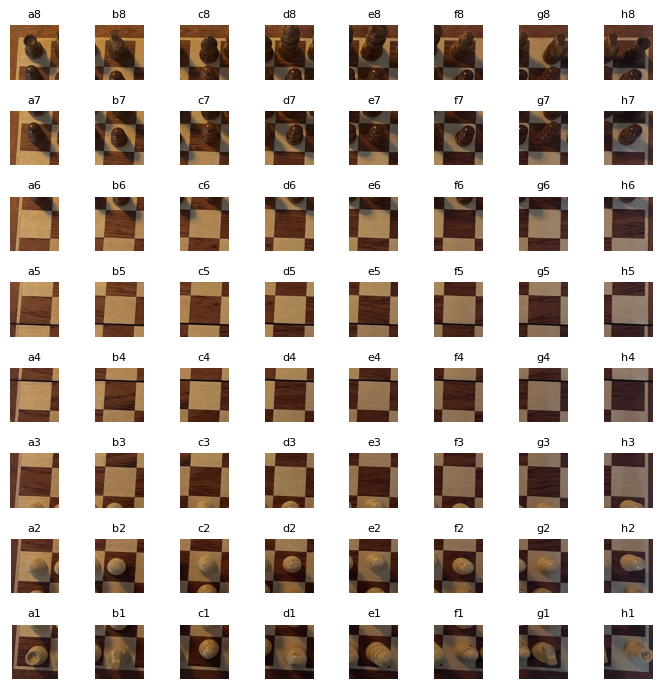

In [ ]:
avg_square_length = square_length(grid_points)
board_mapping = split_image(cropped, grid_center_points, avg_square_length, length_threshold=70, height_threshold=90)
show_cells(board_mapping, fig_length=7, fig_height=7)

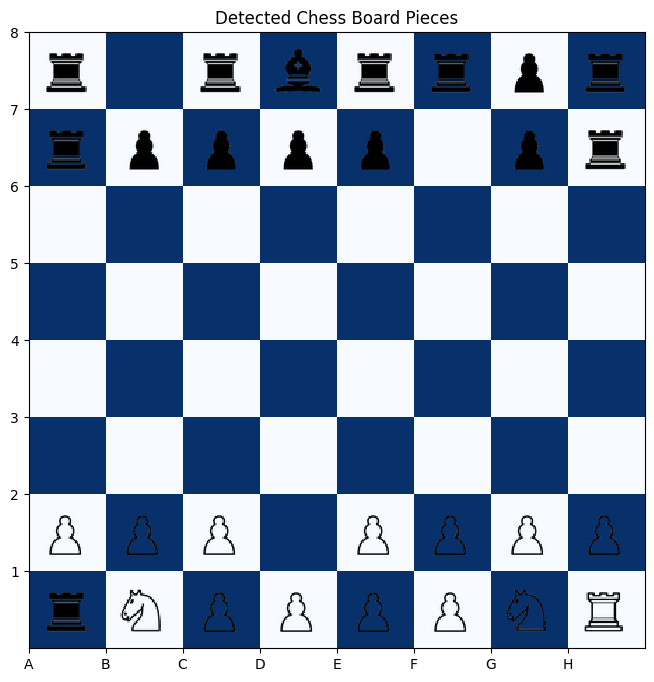

In [ ]:
asset_folder = "./assets"
cells = extract_labeled_cells_from_dict(board_mapping)
reference_embeddings = load_reference_embeddings(asset_folder)
classified_labels = classify_board_cells(cells, reference_embeddings)
visualize_board(classified_labels)

### I.1 Crop and wrap image

In [ ]:
def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
def reorder_points(pts):
    """
    Sort corners into order: 
        [top-left, top-right, bottom-right, bottom-left]
    """
    pts = pts.astype(np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    ordered = np.zeros((4, 2), dtype=np.float32)
    ordered[0] = pts[np.argmin(s)]      # top-left
    ordered[2] = pts[np.argmax(s)]      # bottom-right
    ordered[1] = pts[np.argmin(diff)]   # top-right
    ordered[3] = pts[np.argmax(diff)]   # bottom-left
    return ordered

def detect_corners(img):
    """
    Inspired by Sudoku detection approach:
    1) Grayscale, blur
    2) Adaptive threshold
    3) Morphological closing
    4) Find largest contour that isn't too small or too large
    5) Approximate to 4 corners -> return
    6) Otherwise fallback to rotated bounding box
    """
    # 1) Grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # 2) Adaptive threshold (makes the board region bright/white)
    #    We invert so that the board is white on black background
    thresh = cv2.adaptiveThreshold(
        gray_blur, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11,    # blockSize
        2      # C constant subtracted from mean
    )
    # Invert: the board area becomes white, background black
    thresh = cv2.bitwise_not(thresh)

    # 3) Morphological closing to fill gaps in the board edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4) Find contours in the closed image
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Sort by descending area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    img_area = img.shape[0] * img.shape[1]

    # Attempt to find a 4-corner polygon
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Filter out tiny or massive (entire image) contours
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue

        # Approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # If we get 4 corners, reorder and return
        if len(approx) == 4:
            corners = approx.reshape(4, 2)
            return reorder_points(corners)

    # 5) Fallback: if no 4-corner polygon found, 
    #    use minAreaRect on the largest plausible contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue
        rect = cv2.minAreaRect(cnt)   # ((cx,cy),(w,h),angle)
        box = cv2.boxPoints(rect)     # 4 corner points
        return reorder_points(box)

    return None

def warp_perspective(image, corners):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    image = np.array(image)

    rect = order_points(np.array(corners, dtype="float32"))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

### I.2 Detect chessboard squares

In [ ]:
def detect_straight_lines(edges, threshold=100, min_line_length=50, max_line_gap=10):
    """
    Détecte les lignes droites sur une image de bords (Canny) en utilisant la transformée de Hough.
    :param edges: Image binaire des bords obtenue avec Canny.
    :param threshold: Seuil pour la détection des lignes.
    :param min_line_length: Longueur minimale pour qu'une ligne soit prise en compte.
    :param max_line_gap: Distance max entre deux segments pour être considérés comme une seule ligne.
    :return: Liste des lignes détectées sous forme de tuples (x1, y1, x2, y2).
    """
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    
    return [] if lines is None else [tuple(line[0]) for line in lines]

In [ ]:
def extend_line(x1, y1, x2, y2, img_shape):
    """
    Prolonge une ligne (x1, y1, x2, y2) en respectant son angle, pour qu'elle couvre toute l'image.
    """
    height, width = img_shape[:2]

    # Calcul de l'angle et direction
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)  # Pente de la ligne
        y_intercept = y1 - slope * x1  # Ordonnée à l'origine

        # Prolongement vers la gauche (x = 0) et la droite (x = width)
        x_left, y_left = 0, int(y_intercept)
        x_right, y_right = width, int(slope * width + y_intercept)

        # Clamping des valeurs pour rester dans l'image
        if y_left < 0 or y_left > height:
            y_left = max(0, min(y_left, height))
            x_left = int((y_left - y_intercept) / slope)

        if y_right < 0 or y_right > height:
            y_right = max(0, min(y_right, height))
            x_right = int((y_right - y_intercept) / slope)
        
        return (x_left, y_left, x_right, y_right)

    else:  # Cas particulier d'une ligne verticale
        return (x1, 0, x2, height)

def draw_extended_lines(image, lines):
    """
    Dessine les lignes prolongées sur l'image.
    """
    img_with_lines = image.copy()
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, img_with_lines.shape)
        cv2.line(img_with_lines, (extended_line[0], extended_line[1]), 
                 (extended_line[2], extended_line[3]), (0, 255, 0), 2)

    return img_with_lines

In [ ]:
import math

def extended_lines(lines, image):
    extended_lines = []
    for x1, y1, x2, y2 in lines:
        extended_line = extend_line(x1, y1, x2, y2, image.shape)
        extended_lines.append(extended_line)
    return extended_lines

def avg_extended_lines(lines, image, threshold=30):
    extented_lines = extended_lines(lines, image)
    merged_lines = []
    merged = set()  # Utilisation d'un ensemble pour éviter les doublons et optimiser les recherches

    for x1, y1, x2, y2 in extented_lines:
        if (x1, y1, x2, y2) not in merged:
            to_merge = [(x1, y1, x2, y2)]
            for x3, y3, x4, y4 in extented_lines:
                if (x3, y3, x4, y4) not in merged and (x3, y3, x4, y4) not in to_merge:
                    if math.dist((x1, y1), (x3, y3)) < threshold and math.dist((x2, y2), (x4, y4)) < threshold:
                        to_merge.append((x3, y3, x4, y4))

            # Moyenne des points des lignes fusionnées
            avg_x1 = sum(x[0] for x in to_merge) // len(to_merge)
            avg_y1 = sum(x[1] for x in to_merge) // len(to_merge)
            avg_x2 = sum(x[2] for x in to_merge) // len(to_merge)
            avg_y2 = sum(x[3] for x in to_merge) // len(to_merge)

            # Ajout des lignes fusionnées à l'ensemble des lignes traitées
            merged.update(to_merge)
            merged_lines.append((avg_x1, avg_y1, avg_x2, avg_y2))
        
    return merged_lines

In [ ]:
def classify_lines(lines, img_width, margin=0.1):
    """
    Classe les lignes en quasi-horizontales ou quasi-verticales 
    en fonction de la position de leurs extrémités dans l'image.

    Paramètres :
        - lines : liste des lignes [(x1, y1, x2, y2)]
        - img_width : largeur de l'image (pour évaluer les limites gauche/droite)
        - margin : pourcentage de la largeur de l'image utilisé comme seuil (ex: 10%)

    Retour :
        - horizontal : liste des lignes horizontales
        - vertical : liste des lignes verticales
    """
    horizontal = []
    vertical = []

    left_limit = img_width * margin  # Seuil gauche
    right_limit = img_width * (1 - margin)  # Seuil droit

    for x1, y1, x2, y2 in lines:
        if (min(x1, x2) < left_limit) and (max(x1, x2) > right_limit):  
            horizontal.append((x1, y1, x2, y2))  # Lignes horizontales
        else:
            vertical.append((x1, y1, x2, y2))  # Lignes verticales

    return horizontal, vertical

def find_intersections(lines1, lines2):
    """Trouve les points d'intersection entre deux groupes de lignes en résolvant les équations des droites."""
    pts_on_vertical_lines = {}
    pts_on_horizontal_lines = {}
    intersections = []
    for (x1, y1, x2, y2) in lines1:
        for (x3, y3, x4, y4) in lines2:
            # Calcul des coefficients des droites
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if abs(denom) < 1e-6:  # Lignes parallèles
                continue

            # Calcul des coordonnées d'intersection
            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

            # if 0 <= px <= cropped.shape[1] and 0 <= py <= cropped.shape[0]:  # Vérifie que le point est dans l'image
            intersections.append((int(px), int(py)))

            if (x1, y1, x2, y2) not in pts_on_horizontal_lines:
                pts_on_horizontal_lines[(x1, y1, x2, y2)] = [(int(px),int(py))]
            else:
                pts_on_horizontal_lines[(x1, y1, x2, y2)].append((int(px),int(py)))
            
            if (x3, y3, x4, y4) not in pts_on_vertical_lines:
                pts_on_vertical_lines[(x3, y3, x4, y4)] = [(int(px),int(py))]
            else:
                pts_on_vertical_lines[(x3, y3, x4, y4)].append((int(px),int(py)))

    return intersections, pts_on_horizontal_lines, pts_on_vertical_lines

In [ ]:
def most_regular_segment(points, min_length=8, max_length=9, threshold=0.5):
    """
    Trouve la séquence de 8 ou 9 points les plus régulièrement espacés,
    en priorisant une séquence de 9 si elle est acceptable.
    Si une séquence de 8 est choisie, on ajoute un 9ᵉ point à l'opposé du bord le plus proche.

    :param points: Liste de tuples (x, y) représentant les points d'une droite.
    :param min_length: Longueur minimale du segment (8 par défaut).
    :param max_length: Longueur maximale du segment (9 par défaut).
    :param threshold: Seuil d'écart-type maximal pour considérer une séquence de 9 comme acceptable.
    :return: Liste de 9 points les plus régulièrement espacés.
    """
    n = len(points)
    if n < min_length:
        return points  # Pas assez de points pour former un segment valide

    best_segment_9 = None
    best_segment_8 = None
    min_variation_9 = float('inf')
    min_variation_8 = float('inf')
    best_start_8 = None  # Indice du début du segment de 8

    # Essayer toutes les sous-séquences de taille 8 et 9
    for start in range(n):
        for length in [9, 8]:  # Priorité à 9
            end = start + length
            if end > n:
                continue
            
            segment = points[start:end]

            # Calcul des distances successives entre les points
            distances = [np.linalg.norm(np.array(segment[j+1]) - np.array(segment[j])) for j in range(len(segment) - 1)]
            
            # Calcul de l'écart-type des distances pour mesurer la régularité
            variation = np.std(distances)

            # Vérifier si c'est une séquence de 9 acceptable
            if length == 9 and variation < min_variation_9:
                min_variation_9 = variation
                best_segment_9 = segment

            # Vérifier si c'est une séquence de 8 meilleure
            if length == 8 and variation < min_variation_8:
                min_variation_8 = variation
                best_segment_8 = segment
                best_start_8 = start

    # Si la séquence de 9 est suffisamment régulière, la retourner
    if best_segment_9 and min_variation_9 <= threshold:
        return best_segment_9

    # Sinon, retourner la meilleure séquence de 8 et ajouter un point à l'opposé du bord le plus proche
    if best_segment_8:
        start = best_start_8
        end = start + 8

        # Déterminer les candidats à ajouter (point avant ou après la séquence)
        left_point = points[start - 1] if start > 0 else None
        right_point = points[end] if end < n else None

        # Trouver le bord le plus proche
        if left_point and right_point:
            left_dist = np.linalg.norm(np.array(left_point) - np.array(best_segment_8[0]))
            right_dist = np.linalg.norm(np.array(right_point) - np.array(best_segment_8[-1]))

            if left_dist < right_dist:
                best_segment_8.append(right_point)  # Ajouter à droite (opposé de gauche)
            else:
                best_segment_8.insert(0, left_point)  # Ajouter à gauche (opposé de droite)
        elif left_point:
            best_segment_8.append(left_point)  # Ajouter à droite si possible
        elif right_point:
            best_segment_8.insert(0, right_point)  # Ajouter à gauche si possible

        return best_segment_8

    return None 

def points_to_keep(pts_on_horizontal_lines, pts_on_vertical_lines):
    horizontal_points_to_keep = []
    for line in pts_on_horizontal_lines:
        sorted_points = sorted(pts_on_horizontal_lines[line], key=lambda x: x[0])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in horizontal_points_to_keep:
                horizontal_points_to_keep.append(point)
    
    vertical_points_to_keep = []
    for line in pts_on_vertical_lines:
        sorted_points = sorted(pts_on_vertical_lines[line], key=lambda x: x[1])
        regular_points = most_regular_segment(sorted_points)
        for point in regular_points:
            if point not in vertical_points_to_keep:
                vertical_points_to_keep.append(point)
    
    points_to_keep = [point for point in horizontal_points_to_keep if point in vertical_points_to_keep]
    return points_to_keep

In [ ]:
def group_points_by_y(points, threshold=10, min_points=9):
    grouped_points = []
    temp_group = []
    
    for x, y in sorted(points, key=lambda p: p[1]):
        if not temp_group or abs(temp_group[-1][1] - y) <= threshold:
            temp_group.append((x, y))
        else:
            if len(temp_group) >= min_points:
                grouped_points.append(temp_group)
            temp_group = [(x, y)]
    
    if len(temp_group) >= min_points:
        grouped_points.append(temp_group)
    
    return grouped_points


def center_points(grid_points):
    sorted_grid_points = sorted(grid_points, key=lambda x:x[0]) # Selon x
    sorted_grid_points = sorted(sorted_grid_points, key=lambda x: x[1]) # Selon y
    points_per_lines = group_points_by_y(sorted_grid_points)

    center_points = []

    lines_nb = len(points_per_lines)
    for line_i in range(lines_nb-1):
        line0 = points_per_lines[line_i]
        line1 = points_per_lines[line_i+1]

        points_nb = min(len(line0), len(line1))
        for point_i in range(points_nb-1):
            x_point0, y_point0 = line0[point_i]
            x_point1, y_point1 = line0[point_i+1]
            x_point2, y_point2 = line1[point_i]
            x_point3, y_point3 = line1[point_i+1]

            x_center_point = ( x_point0 + x_point1 + x_point2 + x_point3 ) // 4
            y_center_point = ( y_point0 + y_point1 + y_point2 + y_point3 ) // 4
            center_points.append((x_center_point, y_center_point))
    
    return center_points

In [ ]:
def square_length(grid_points):
    sorted_grid_points = sorted(grid_points, key=lambda x:x[0]) # Selon x
    sorted_grid_points = sorted(sorted_grid_points, key=lambda x: x[1]) # Selon y
    points_per_lines = group_points_by_y(sorted_grid_points)

    tot_square_length = 0
    nb1 = 0
    for line in points_per_lines:
        points_nb = len(line)
        for i in range(points_nb-1):
            x1, y1 = line[i]
            x2, y2 = line[i+1]
            dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            tot_square_length += dist
            nb1 += 1
    
    tot_square_height = 0
    nb2 = 0
    nb_lines = len(points_per_lines)
    for i in range(nb_lines-1):
        line0, line1 = points_per_lines[i], points_per_lines[i+1]
        points_nb = min(len(line0), len(line1))
        for j in range(points_nb):
            x0, y0 = line0[j]
            x1, y1 = line1[j]
            dist = math.sqrt((x1-x0)**2 + (y1-y0)**2)
            tot_square_height += dist
            nb2 += 1
    
    avg_square_length = int((tot_square_length + tot_square_height) // (nb1 + nb2)) // 2
    return avg_square_length

In [ ]:
def show_cells(cells_dict, grid_size=8):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    labels = sorted(cells_dict.keys())
    
    for idx, label in enumerate(labels):
        i, j = divmod(idx, grid_size)
        cell_rgb = cv2.cvtColor(cells_dict[label], cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(cell_rgb)
        axs[i, j].axis('off')
        axs[i, j].set_title(label, fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def split_image(img, center_points, avg_square_length, length_threshold=10, height_threshold=50):
    board_mapping = {}
    chess_columns = 'abcdefgh'
    
    for idx, (i, j) in enumerate(center_points):
        row = 8 - (idx // 8)
        col = chess_columns[idx % 8]
        position = f"{col}{row}"
        
        x_start, y_start = max(int(i - avg_square_length - length_threshold / 2), 0) , max(int(j - avg_square_length - height_threshold/ 2), 0)
        x_end, y_end = min(int(i + avg_square_length + length_threshold/ 2), img.shape[0]), min(int(j + avg_square_length +height_threshold / 2), img.shape[1])
        
        split_img = img[y_start:y_end, x_start:x_end]
        board_mapping[position] = split_img
    
    return board_mapping

In [ ]:
def show_cells(cells_dict, fig_length=6, fig_height=6):
    grid_size=8
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(fig_length, fig_height))
    labels = sorted(cells_dict.keys(), key=lambda label: (int(label[1]), label[0]))
    
    for idx, label in enumerate(labels):
        i, j = divmod(idx, grid_size)
        i = grid_size - 1 - i  # Inverser l'axe vertical pour que 'a' soit en bas
        cell = cells_dict[label]
        if cell is not None and cell.size > 0:
            cell_rgb = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(cell_rgb)
        else:
            axs[i, j].imshow(np.zeros((10, 10, 3), dtype=np.uint8))
        axs[i, j].axis('off')
        axs[i, j].set_title(label, fontsize=8)
    
    plt.tight_layout()
    plt.show()

### I.4 Piece detection

In [ ]:
# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load DINOv2 Model and Processor ---
model_id = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_id)
model = Dinov2Model.from_pretrained(model_id).to(device)
model.eval()

# --- Preprocess image for DINOv2 ---
def preprocess(image):
    inputs = processor(images=image, return_tensors="pt")
    return inputs['pixel_values'].to(device)

# --- Extract feature embedding ---
def get_embedding(image):
    with torch.no_grad():
        pixel_values = preprocess(image)
        outputs = model(pixel_values)
        embedding = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        return embedding.squeeze()

# --- Load reference piece embeddings ---
def load_reference_embeddings(asset_folder):
    references = {}
    for label in os.listdir(asset_folder):
        label_path = os.path.join(asset_folder, label)
        if os.path.isdir(label_path):
            embeddings = []
            for file in os.listdir(label_path):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(label_path, file)
                    img = Image.open(img_path).convert("RGB")
                    emb = get_embedding(img)
                    embeddings.append(emb)
            if embeddings:
                # Average embeddings for this class
                stacked = torch.stack(embeddings)
                references[label] = stacked.mean(dim=0)
    return references

# --- Cosine similarity ---
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

# --- Compare each square to references ---
def classify_board_cells(cell_images, reference_embeddings):
    results = []
    for img in cell_images:
        emb = get_embedding(img)
        similarities = {
            label: cosine_similarity(emb, ref_emb) for label, ref_emb in reference_embeddings.items()
        }
        top3 = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:3]
        top3_labels = [label for label, _ in top3]
        label_counts = Counter(top3_labels)
        most_common = label_counts.most_common(1)[0]
        if most_common[1] > 1:
            final_label = most_common[0]
        else:
            final_label = top3_labels[0]
        results.append(final_label)
    return results

# --- Chess notation helper ---
def get_notation(row, col):
    return f"{chr(ord('A') + col)}{8 - row}"

### I.5 Chessboard visualisation

In [ ]:
def remove_checkerboard_background(img):
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        r, g, b, a = item
        if r > 200 and g > 200 and b > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append((r, g, b, a))
    img.putdata(newData)
    return img

def visualize_board(classified_labels):
    board = np.array(classified_labels).reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels([chr(i) for i in range(65, 73)])
    ax.set_yticklabels(list(reversed(range(1, 9))))
    ax.imshow([[1 if (i + j) % 2 == 0 else 0.7 for j in range(8)] for i in range(8)],
              cmap='Blues', extent=(0, 8, 0, 8))

    for i in range(8):
        for j in range(8):
            piece = board[i][j]
            if piece not in ["white_cell", "black_cell"]:
                image_path = os.path.join("./2d_assets", piece, f"{piece}.png")
                if os.path.exists(image_path):
                    img = Image.open(image_path)
                    img = remove_checkerboard_background(img)
                    img = img.resize((40, 40), resample=Image.Resampling.LANCZOS)
                    im = OffsetImage(img, zoom=1, interpolation='none')
                    ab = AnnotationBbox(im, (j + 0.5, i + 0.5), frameon=False)
                    ax.add_artist(ab)

    plt.grid(False)
    plt.title("Detected Chess Board Pieces")
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.gca().invert_yaxis()
    plt.show()


In [ ]:
def extract_labeled_cells_from_dict(image_dict, grid_size=8):
    all_cells = []

    files = 'abcdefgh'
    ranks = '87654321'

    for i in range(grid_size):
        for j in range(grid_size):
            _key_ = files[j] + ranks[i]
            for key, image in image_dict.items():
                if key == _key_:
                    all_cells.append(image)

    return all_cells

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon, box

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import torch
from torchvision import transforms
from transformers import AutoImageProcessor, Dinov2Model

In [ ]:
chessboard_folder = 'data/chessboard'
chess_pieces_folder = 'data/chess_pieces'

INPUT_SIZE = 1080